# AI-Powered Student Analytics

## A True Multi-Agent System with LLMs

This demonstrates **real AI agents** using LLMs to collaboratively analyze student data.

### The Agents

Each agent uses `chat()` to make intelligent decisions:

- 🧠 **Question Analyst** - Uses LLM to understand what the user is asking
- 💾 **SQL Generator** - Uses LLM to write SQL queries from natural language
- 📊 **Data Interpreter** - Uses LLM to find insights in numerical results
- 📈 **Visualization Agent** - Uses LLM to intelligently create charts when helpful
- ✍️ **Report Writer** - Uses LLM to compose natural language reports

**No hardcoded patterns!** Each agent thinks for itself using AI.

### The Praval Way

Agents self-organize through messages. No coordinator - just intelligent collaboration!

The **Data Interpreter** and **Visualization Agent** run in parallel - both respond to the same message type!

## Setup

In [1]:
import sys
import os
from pathlib import Path

# Add parent directory to path
parent_dir = Path(os.getcwd()).parent / 'src'
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

# Load environment variables
from dotenv import load_dotenv
project_root = Path(os.getcwd()).parent
env_file = project_root / '.env'
if env_file.exists():
    load_dotenv(env_file)
    print("✅ Loaded .env file")

# Check for API key
if not os.getenv('OPENAI_API_KEY'):
    print("⚠️ No OPENAI_API_KEY found!")
    print("Set it: os.environ['OPENAI_API_KEY'] = 'your-key'")
else:
    print("✅ OpenAI API key found")

# Import Praval
from praval import agent, start_agents, broadcast, chat

# Import other libraries
import sqlite3
import random
from datetime import datetime, timedelta
import json

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
matplotlib.use('Agg')  # Use non-interactive backend for notebook
%matplotlib inline

print("✅ All imports successful!")

✅ Loaded .env file
✅ OpenAI API key found
✅ All imports successful!


## Create Student Database

Same database as before, but now our agents will use AI to analyze it.

In [2]:
def create_student_database(db_path="students.db", num_students_per_section=18):
    """Create and populate the student database."""
    
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Create tables
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS students (
            id INTEGER PRIMARY KEY,
            name TEXT NOT NULL,
            grade INTEGER NOT NULL,
            section TEXT NOT NULL
        )
    """)
    
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS scores (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            student_id INTEGER NOT NULL,
            subject TEXT NOT NULL,
            score INTEGER NOT NULL,
            test_date TEXT NOT NULL,
            FOREIGN KEY (student_id) REFERENCES students(id)
        )
    """)
    
    # Clear existing data
    cursor.execute("DELETE FROM scores")
    cursor.execute("DELETE FROM students")
    
    # Generate data
    first_names = ["Aarav", "Vivaan", "Aditya", "Vihaan", "Arjun", "Sai", "Arnav", "Krishna",
                   "Ishaan", "Aadhya", "Ananya", "Pari", "Anika", "Diya", "Ishita", "Navya",
                   "Saanvi", "Sara", "Priya", "Riya", "Kiara", "Avni", "Kavya", "Myra", "Aditi"]
    last_names = ["Sharma", "Verma", "Tudu", "Yadav", "Patel", "Karthikeyan", "Reddy", "Shyam",
                  "Menon", "Nair", "Joshi", "Manocha", "Nuthulapati", "Iyer", "Bhaskar", "Srinivas"]
    
    grades = [6, 7, 8, 9, 10]
    sections = ["A", "B", "C", "D"]
    subjects = ["Mathematics", "Science", "English", "Hindi", "Social Studies"]
    
    student_id = 1
    students_data = []
    
    for grade in grades:
        for section in sections:
            for _ in range(num_students_per_section):
                name = f"{random.choice(first_names)} {random.choice(last_names)}"
                students_data.append((student_id, name, grade, section))
                student_id += 1
    
    cursor.executemany(
        "INSERT INTO students (id, name, grade, section) VALUES (?, ?, ?, ?)",
        students_data
    )
    
    # Generate scores
    scores_data = []
    base_date = datetime.now() - timedelta(days=90)
    
    for student_id, _, grade, _ in students_data:
        for subject in subjects:
            base_score = 50 + (grade - 6) * 5
            if subject == "Mathematics":
                score = base_score + random.randint(-15, 20)
            elif subject == "Science":
                score = base_score + random.randint(-10, 20)
            else:
                score = base_score + random.randint(-10, 15)
            
            score = max(0, min(100, score))
            test_date = (base_date + timedelta(days=random.randint(0, 30))).strftime("%Y-%m-%d")
            scores_data.append((student_id, subject, score, test_date))
    
    cursor.executemany(
        "INSERT INTO scores (student_id, subject, score, test_date) VALUES (?, ?, ?, ?)",
        scores_data
    )
    
    conn.commit()
    conn.close()
    
    print(f"✅ Created {len(students_data)} students")
    print(f"✅ Created {len(scores_data)} test scores")
    print(f"💾 Database: {db_path}")
    
    return db_path

DB_PATH = create_student_database()

✅ Created 360 students
✅ Created 1800 test scores
💾 Database: students.db


## Database Schema

This schema will be provided to LLM-powered agents.

In [3]:
DATABASE_SCHEMA = """
Table: students
- id (INTEGER, PRIMARY KEY): Unique student identifier
- name (TEXT): Student's full name
- grade (INTEGER): Grade level (6, 7, 8, 9, or 10)
- section (TEXT): Section (A, B, C, or D)

Table: scores
- id (INTEGER, PRIMARY KEY): Unique score record
- student_id (INTEGER, FOREIGN KEY): References students.id
- subject (TEXT): One of: Mathematics, Science, English, Hindi, Social Studies
- score (INTEGER): Test score (0-100)
- test_date (TEXT): Date in YYYY-MM-DD format

Relationship: students.id → scores.student_id (one-to-many)
"""

print("Database Schema:")
print(DATABASE_SCHEMA)

Database Schema:

Table: students
- id (INTEGER, PRIMARY KEY): Unique student identifier
- name (TEXT): Student's full name
- grade (INTEGER): Grade level (6, 7, 8, 9, or 10)
- section (TEXT): Section (A, B, C, or D)

Table: scores
- id (INTEGER, PRIMARY KEY): Unique score record
- student_id (INTEGER, FOREIGN KEY): References students.id
- subject (TEXT): One of: Mathematics, Science, English, Hindi, Social Studies
- score (INTEGER): Test score (0-100)
- test_date (TEXT): Date in YYYY-MM-DD format

Relationship: students.id → scores.student_id (one-to-many)



---

# AI-Powered Agents

Now let's build agents that use LLMs to make intelligent decisions!

## Agent 1: Question Analyst 🧠

Uses LLM to deeply understand what the user is asking.

In [4]:
@agent("question_analyst", channel="analytics", responds_to=["user_query"])
def question_analyst_agent(spore):
    """
    I use AI to deeply understand user questions about student data.
    I extract key entities, intent, and requirements from questions.
    """
    question = spore.knowledge.get("question")
    db_path = spore.knowledge.get("db_path")
    
    print(f"🧠 Question Analyst: Analyzing '{question}'...\n")
    
    try:
        # Use LLM to understand the question
        analysis = chat(f"""
Analyze this question about student performance data:

Question: "{question}"

Extract:
1. What metrics are they asking for? (averages, counts, top performers, etc.)
2. What filters or groupings? (by grade, section, subject, etc.)
3. What entities? (students, subjects, sections, grades)
4. Any sorting or limits?

Respond in JSON format:
{{
  "intent": "brief description of what they want",
  "metrics": ["list of metrics"],
  "filters": ["list of filters"],
  "entities": ["relevant entities"],
  "notes": "any other important details"
}}
""")
        
        # Parse the JSON response
        # Extract JSON from markdown code blocks if present
        analysis_text = analysis.strip()
        if "```json" in analysis_text:
            analysis_text = analysis_text.split("```json")[1].split("```")[0].strip()
        elif "```" in analysis_text:
            analysis_text = analysis_text.split("```")[1].strip()
        
        parsed = json.loads(analysis_text)
        
        print(f"🧠 Intent: {parsed.get('intent', 'N/A')}")
        print(f"🧠 Metrics: {', '.join(parsed.get('metrics', []))}")
        print(f"🧠 Filters: {', '.join(parsed.get('filters', []))}\n")
        
    except Exception as e:
        print(f"🧠 Analysis (fallback): Understanding the question...\n")
        parsed = {
            "intent": "Analyze student performance",
            "metrics": ["performance data"],
            "filters": ["based on question"],
            "entities": ["students", "scores"]
        }
    
    # Broadcast analysis to SQL generator
    broadcast({
        "type": "generate_sql",
        "question": question,
        "analysis": parsed,
        "schema": DATABASE_SCHEMA,
        "db_path": db_path
    }, channel="analytics")
    
    return {"analysis": parsed}

print("✅ Question Analyst agent created")

✅ Question Analyst agent created


## Agent 2: SQL Generator 💾

Uses LLM to write SQL queries from natural language.

In [5]:
@agent("sql_generator", channel="analytics", responds_to=["generate_sql"])
def sql_generator_agent(spore):
    """
    I use AI to write SQL queries from natural language questions.
    I understand database schemas and SQL best practices.
    """
    question = spore.knowledge.get("question")
    analysis = spore.knowledge.get("analysis")
    schema = spore.knowledge.get("schema")
    db_path = spore.knowledge.get("db_path")
    
    print(f"💾 SQL Generator: Writing query...\n")
    
    try:
        # Use LLM to generate SQL
        sql_response = chat(f"""
Write a SQL query to answer this question:

Question: "{question}"

Intent analysis: {json.dumps(analysis, indent=2)}

Database schema:
{schema}

Requirements:
1. Write a single, efficient SQL query
2. Use proper JOINs where needed
3. Include appropriate GROUP BY, ORDER BY, LIMIT clauses
4. Use meaningful column aliases
5. Only SELECT, no modifications

Respond with ONLY the SQL query, no explanation.
""")
        
        # Clean up the SQL (remove markdown formatting if present)
        query = sql_response.strip()
        if "```sql" in query:
            query = query.split("```sql")[1].split("```")[0].strip()
        elif "```" in query:
            query = query.split("```")[1].strip()
        
        print(f"💾 Generated SQL:")
        print(query)
        print()
        
    except Exception as e:
        print(f"💾 Error generating SQL: {e}")
        # Fallback to a safe default query
        query = "SELECT COUNT(*) as total_students FROM students"
        print(f"💾 Using fallback query\n")
    
    # Broadcast query to executor
    broadcast({
        "type": "execute_query",
        "query": query,
        "question": question,
        "db_path": db_path
    }, channel="analytics")
    
    return {"query": query}

print("✅ SQL Generator agent created")

✅ SQL Generator agent created


## Agent 3: Query Executor ⚙️

Safely executes SQL queries (same as before - no LLM needed here).

In [6]:
@agent("query_executor", channel="analytics", responds_to=["execute_query"])
def query_executor_agent(spore):
    """
    I execute SQL queries safely and return results.
    """
    query = spore.knowledge.get("query")
    db_path = spore.knowledge.get("db_path")
    question = spore.knowledge.get("question")
    
    print(f"⚙️ Query Executor: Running query...")
    
    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        cursor.execute(query)
        results = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]
        conn.close()
        
        print(f"⚙️ Retrieved {len(results)} rows\n")
        
        # Convert to list of dicts for easier LLM processing
        results_dicts = []
        for row in results[:50]:  # Limit to first 50 for LLM context
            results_dicts.append(dict(zip(columns, row)))
        
        broadcast({
            "type": "interpret_data",
            "results": results_dicts,
            "columns": columns,
            "row_count": len(results),
            "question": question
        }, channel="analytics")
        
        return {"results": results_dicts}
    
    except Exception as e:
        print(f"❌ Error executing query: {e}\n")
        return {"error": str(e)}

print("✅ Query Executor agent created")

✅ Query Executor agent created


## Agent 4: Visualization Agent 📈

Uses LLM to **generate matplotlib code** dynamically!

**Key Innovation:**
- LLM analyzes the data and question
- LLM writes custom Python/matplotlib code
- Code is executed safely to create the chart
- No templates - truly creative visualizations!

**Runs in parallel with Data Interpreter!** Both respond to `interpret_data`.

In [7]:
@agent("visualizer", channel="analytics", responds_to=["interpret_data"])
def visualization_agent(spore):
    """
    I use AI to creatively visualize data by generating matplotlib code.
    I analyze the data and write custom Python code to create insightful charts.
    """
    results = spore.knowledge.get("results")
    columns = spore.knowledge.get("columns")
    row_count = spore.knowledge.get("row_count")
    question = spore.knowledge.get("question")
    
    print(f"📈 Visualizer: Analyzing if visualization would be helpful...\n")
    
    # Only visualize if we have reasonable amount of data
    if row_count == 0 or row_count > 100:
        print(f"📈 Skipping visualization (row count: {row_count})\n")
        return {"visualized": False}
    
    try:
        # Use LLM to decide and generate visualization code
        viz_code = chat(f"""
Analyze this student performance data and create a visualization if helpful.

Question: "{question}"
Data columns: {columns}
Number of rows: {row_count}
Sample data (first 5 rows): {json.dumps(results[:5], indent=2)}
Full data: {json.dumps(results, indent=2)}

Task:
1. Decide if visualization would add value
2. If yes, write creative matplotlib code to visualize this data

IMPORTANT: 
- The data is available as a list of dictionaries in the variable `data`
- matplotlib.pyplot is ALREADY IMPORTED as `plt` - DO NOT import it again
- pandas is ALREADY IMPORTED as `pd` - DO NOT import it again
- DO NOT include any import statements in your code
- Start directly with creating the visualization

Requirements:
- Write complete, executable Python code (NO IMPORTS!)
- Be creative! Use colors, labels, annotations, grids, etc.
- Choose the best chart type for the data (bar, line, scatter, multiple subplots, etc.)
- Add a descriptive title and axis labels
- Make it visually appealing
- The code should create a figure and call plt.show()

If visualization wouldn't add value, respond with: NO_VIZ

Otherwise, respond with ONLY the Python code (NO IMPORTS!), no explanation.
Start directly with extracting data from the `data` variable.
""")
        
        # Check if visualization is appropriate
        if "NO_VIZ" in viz_code:
            print(f"📈 Skipping visualization: Not helpful for this query\n")
            return {"visualized": False}
        
        print(f"📈 Generating custom visualization code...\n")
        
        # Clean up the code (remove markdown if present)
        code = viz_code.strip()
        if "```python" in code:
            code = code.split("```python")[1].split("```")[0].strip()
        elif "```" in code:
            code = code.split("```")[1].strip()
        
        # Remove any import statements (in case LLM includes them despite instructions)
        lines = code.split('\n')
        filtered_lines = []
        for line in lines:
            stripped = line.strip()
            if not (stripped.startswith('import ') or stripped.startswith('from ') and ' import ' in stripped):
                filtered_lines.append(line)
            else:
                print(f"📈 Stripped import statement: {stripped}")
        code = '\n'.join(filtered_lines)
        
        print(f"📈 Executing AI-generated visualization code:\n")
        print("="*70)
        print(code)
        print("="*70 + "\n")
        
        # Create safe execution environment
        safe_globals = {
            'plt': plt,
            'pd': __import__('pandas'),
            'data': results,
            'columns': columns,
            'json': json,
            '__builtins__': {
                'len': len,
                'range': range,
                'enumerate': enumerate,
                'zip': zip,
                'list': list,
                'dict': dict,
                'str': str,
                'int': int,
                'float': float,
                'bool': bool,
                'print': print,
                'sum': sum,
                'max': max,
                'min': min,
                'sorted': sorted,
                'round': round,
                'abs': abs,
                'any': any,
                'all': all,
                'isinstance': isinstance,
                'type': type,
            }
        }
        
        # Execute the generated code
        exec(code, safe_globals)
        
        print(f"\n📈 Visualization complete!\n")
        
        return {"visualized": True, "code": code}
        
    except Exception as e:
        print(f"📈 Could not create visualization: {e}\n")
        import traceback
        traceback.print_exc()
        return {"visualized": False, "error": str(e)}

print("✅ Visualization Agent created (AI-powered code generation!)")

✅ Visualization Agent created (AI-powered code generation!)


## Agent 5: Data Interpreter 📊

Uses LLM to find insights and patterns in the numerical results.

**Runs in parallel with Visualization Agent!** Both respond to `interpret_data`.

In [8]:
@agent("data_interpreter", channel="analytics", responds_to=["interpret_data"])
def data_interpreter_agent(spore):
    """
    I use AI to interpret query results and find meaningful insights.
    I identify trends, outliers, and patterns in the data.
    """
    results = spore.knowledge.get("results")
    columns = spore.knowledge.get("columns")
    row_count = spore.knowledge.get("row_count")
    question = spore.knowledge.get("question")
    
    print(f"📊 Data Interpreter: Analyzing {row_count} rows...\n")
    
    try:
        # Use LLM to interpret the data
        interpretation = chat(f"""
Analyze this student performance data:

Original Question: "{question}"

Query Results ({row_count} total rows, showing first {len(results)}):
{json.dumps(results, indent=2)}

Find insights:
1. What are the key findings?
2. Any notable patterns or trends?
3. Any concerns or areas of excellence?
4. What stands out?

Provide 3-5 concise, actionable insights.
Be specific with numbers and comparisons.
""")
        
        print(f"📊 Key Insights:")
        print(interpretation)
        print()
        
    except Exception as e:
        print(f"📊 Error interpreting data: {e}")
        interpretation = f"Found {row_count} records matching the query."
        print(f"📊 Fallback: {interpretation}\n")
    
    # Broadcast to report writer
    broadcast({
        "type": "write_report",
        "insights": interpretation,
        "results_sample": results[:10],  # Send sample for context
        "row_count": row_count,
        "question": question
    }, channel="analytics")
    
    return {"insights": interpretation}

print("✅ Data Interpreter agent created")

✅ Data Interpreter agent created


## Agent 6: Report Writer ✍️

Uses LLM to compose professional, natural language reports.

In [9]:
@agent("report_writer", channel="analytics", responds_to=["write_report"])
def report_writer_agent(spore):
    """
    I use AI to write clear, professional reports for end users.
    I synthesize insights into actionable narratives.
    """
    insights = spore.knowledge.get("insights")
    question = spore.knowledge.get("question")
    row_count = spore.knowledge.get("row_count")
    
    print(f"✍️ Report Writer: Composing report...\n")
    
    try:
        # Use LLM to write a polished report
        report = chat(f"""
Write a professional analytics report:

Question Asked: "{question}"

Data Analysis:
{insights}

Write a clear, concise report that:
1. Directly answers the question
2. Highlights the most important findings
3. Provides context and comparisons
4. Suggests actions if appropriate
5. Uses a professional but accessible tone

Keep it under 200 words.
""")
        
        print("="*70)
        print("STUDENT ANALYTICS REPORT")
        print("="*70)
        print(f"\nQuestion: {question}\n")
        print(report)
        print("\n" + "="*70)
        print("✅ Report complete\n")
        
    except Exception as e:
        print(f"✍️ Error writing report: {e}")
        print(f"\nInsights:\n{insights}\n")
    
    return {"report": report if 'report' in locals() else insights}

print("✅ Report Writer agent created")

✅ Report Writer agent created


---

# Run AI-Powered Analytics!

Now let's ask questions and watch the AI agents collaborate.

## Query 1: Overall Performance

In [15]:
import time

start_agents(
    question_analyst_agent,
    sql_generator_agent,
    query_executor_agent,
    data_interpreter_agent,
    report_writer_agent,
    initial_data={
        "type": "user_query",
        "question": "How are students performing overall across all subjects?",
        "db_path": DB_PATH
    }
)

time.sleep(1)  # Allow agents to complete

🧠 Question Analyst: Analyzing 'How are students performing overall across all subjects?'...

🧠 Intent: Understand overall student performance across all subjects
🧠 Metrics: overall performance
🧠 Filters: across all subjects

💾 SQL Generator: Writing query...

💾 Generated SQL:
SELECT s.name AS student_name, AVG(sc.score) AS average_score
FROM students s
JOIN scores sc ON s.id = sc.student_id
GROUP BY s.id, s.name;

⚙️ Query Executor: Running query...
⚙️ Retrieved 360 rows

📊 Data Interpreter: Analyzing 360 rows...

📈 Visualizer: Analyzing if visualization would be helpful...

📈 Skipping visualization (row count: 360)

📊 Key Insights:
**Key Findings:**
1. Students' average scores vary from 46.0 to 61.4, indicating a range of academic performance levels across the student population.
2. Some students show consistent performance in the mid-range, while others exhibit higher or lower average scores, showcasing diversity in academic abilities.
3. The top-performing students have average scor

## Query 2: Grade Comparison

🧠 Question Analyst: Analyzing 'Compare the average scores across different grades'...

🧠 Intent: Compare average scores across different grades
🧠 Metrics: average scores
🧠 Filters: by grades

💾 SQL Generator: Writing query...

💾 Generated SQL:
SELECT grade,
       AVG(score) AS average_score
FROM students
JOIN scores ON students.id = scores.student_id
GROUP BY grade;

⚙️ Query Executor: Running query...
⚙️ Retrieved 5 rows

📊 Data Interpreter: Analyzing 5 rows...

📈 Visualizer: Analyzing if visualization would be helpful...

📈 Generating custom visualization code...

📈 Executing AI-generated visualization code:

grades = [d['grade'] for d in data]
average_scores = [d['average_score'] for d in data]

plt.figure(figsize=(10, 6))
plt.plot(grades, average_scores, marker='o', color='purple', linestyle='-', linewidth=2, markersize=8)
plt.title('Average Scores Across Different Grades')
plt.xlabel('Grade')
plt.ylabel('Average Score')
plt.xticks(grades)
plt.grid(axis='y', linestyle='--', alpha=

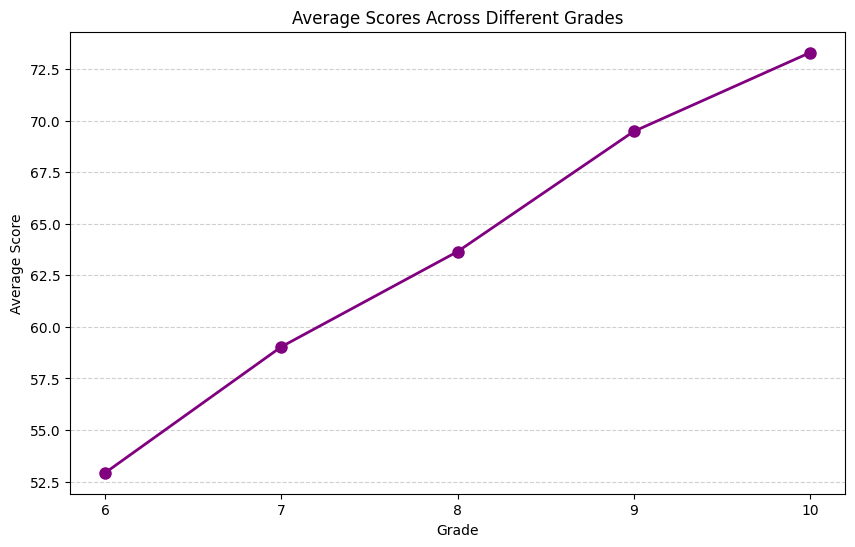


📈 Visualization complete!

📊 Key Insights:
**Key Findings:**
1. Average scores increase progressively with each grade level, from grade 6 to grade 10, demonstrating improvement in academic performance as students advance through the grades.
2. Grade 10 has the highest average score of 73.29, indicating the highest level of academic achievement among the different grade levels.
3. There is a clear positive correlation between grade level and average scores, reflecting a trend of academic growth and development over the years.
4. Grade 6 has the lowest average score, suggesting a potential need for additional support and intervention to help students in this grade level improve their academic performance.
5. The average scores show a consistent upward trend, indicating overall progress and advancement in student learning as they move towards higher grades.

**Actionable Insights:**
1. Implement targeted support programs for students in grade 6 to address academic challenges and provide 

In [16]:
start_agents(
    question_analyst_agent,
    sql_generator_agent,
    query_executor_agent,
    visualization_agent,  # Runs in parallel with data_interpreter
    data_interpreter_agent,
    report_writer_agent,
    initial_data={
        "type": "user_query",
        "question": "Compare the average scores across different grades",
        "db_path": DB_PATH
    }
)

time.sleep(1)

## Query 3: Top Performers

🧠 Question Analyst: Analyzing 'Who are the top 5 students and what makes them stand out?'...



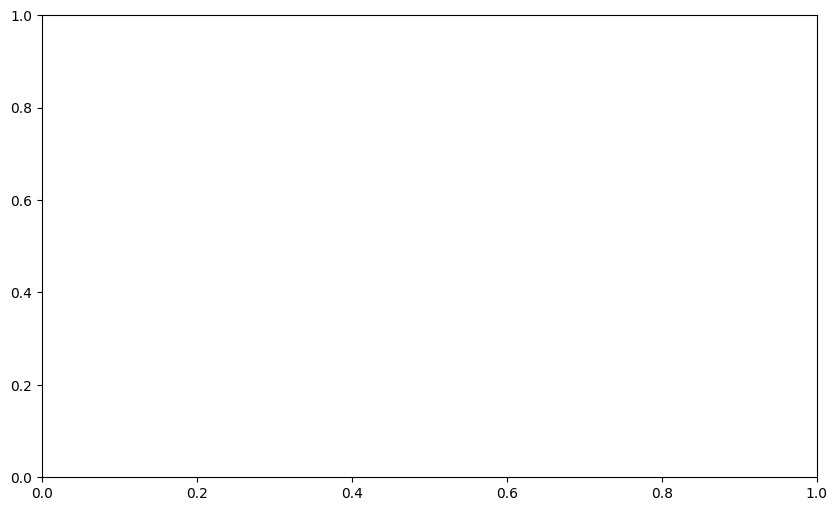

🧠 Intent: Identify the top 5 students and reasons for their outstanding performance
🧠 Metrics: top performers
🧠 Filters: 

💾 SQL Generator: Writing query...

💾 Generated SQL:
SELECT s.name AS student_name, AVG(sc.score) AS average_score
FROM students s
JOIN scores sc ON s.id = sc.student_id
GROUP BY s.id, s.name
ORDER BY average_score DESC
LIMIT 5;

⚙️ Query Executor: Running query...
⚙️ Retrieved 5 rows

📊 Data Interpreter: Analyzing 5 rows...

📈 Visualizer: Analyzing if visualization would be helpful...

📈 Generating custom visualization code...

📈 Executing AI-generated visualization code:

student_names = [d['student_name'] for d in data]
average_scores = [d['average_score'] for d in data]

plt.figure(figsize=(10, 6))
plt.barh(student_names, average_scores, color='skyblue')
plt.title('Top 5 Students and Their Average Scores')
plt.xlabel('Average Score')
plt.ylabel('Student Name')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()



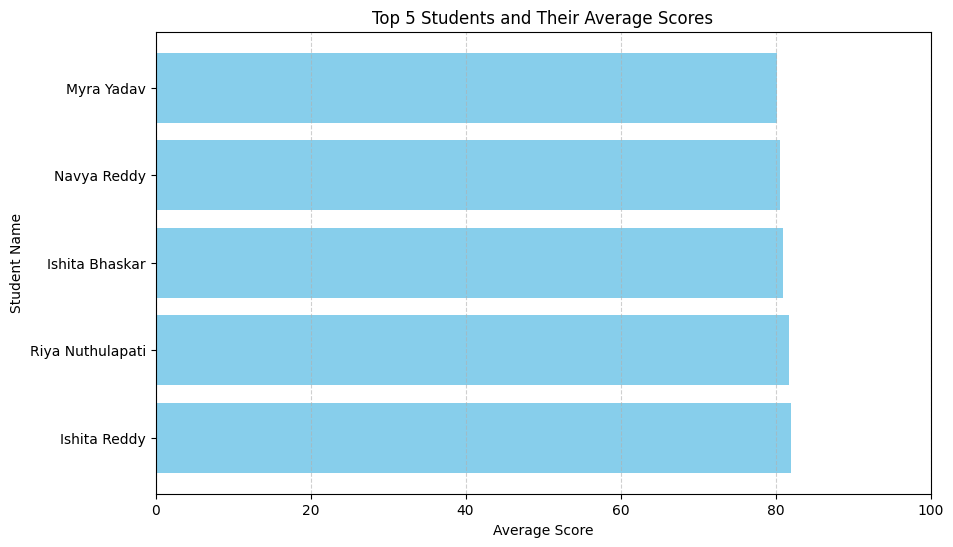


📈 Visualization complete!

📊 Key Insights:
**Key Findings:**
1. The top 5 students have average scores ranging from 82.0 to 80.2, indicating exceptional academic performance and proficiency.
2. Ishita Reddy, Riya Nuthulapati, Ishita Bhaskar, Navya Reddy, and Myra Yadav stand out as the top-performing students based on their high average scores.
3. These top students demonstrate consistent excellence in their academic achievements, showcasing dedication, hard work, and mastery of the subject matter.
4. The top 5 students have average scores significantly higher than the rest of the student population, highlighting their exceptional academic capabilities and commitment to learning.

**Actionable Insights:**
1. Recognize and celebrate the achievements of the top 5 students to motivate and inspire other students to strive for academic excellence.
2. Provide opportunities for the top-performing students to mentor and support their peers, fostering a culture of collaboration and academic gr

In [18]:
start_agents(
    question_analyst_agent,
    sql_generator_agent,
    query_executor_agent,
    data_interpreter_agent,
    report_writer_agent,
    initial_data={
        "type": "user_query",
        "question": "Who are the top 5 students and what makes them stand out?",
        "db_path": DB_PATH
    }
)

time.sleep(1)

## Query 4: Subject Analysis

In [13]:
start_agents(
    question_analyst_agent,
    sql_generator_agent,
    query_executor_agent,
    data_interpreter_agent,
    report_writer_agent,
    initial_data={
        "type": "user_query",
        "question": "Which subject is the most challenging for students and why?",
        "db_path": DB_PATH
    }
)

time.sleep(1)

🧠 Question Analyst: Analyzing 'Which subject is the most challenging for students and why?'...

💾 Generated SQL:
SELECT s.name AS student_name, AVG(score) AS average_score
FROM students s
JOIN scores sc ON s.id = sc.student_id
GROUP BY s.id, s.name
ORDER BY average_score DESC;

⚙️ Query Executor: Running query...
⚙️ Retrieved 360 rows

📈 Visualizer: Analyzing if visualization would be helpful...

📈 Skipping visualization (row count: 360)

📊 Data Interpreter: Analyzing 360 rows...



## Query 5: Students Needing Support

In [14]:
start_agents(
    question_analyst_agent,
    sql_generator_agent,
    query_executor_agent,
    data_interpreter_agent,
    report_writer_agent,
    initial_data={
        "type": "user_query",
        "question": "Which students are struggling and need extra support?",
        "db_path": DB_PATH
    }
)

time.sleep(1)

🧠 Question Analyst: Analyzing 'Which students are struggling and need extra support?'...

🧠 Intent: Identifying the top performing students and reasons for their outstanding performance
🧠 Metrics: top performers
🧠 Filters: 

💾 SQL Generator: Writing query...

💾 Generated SQL:
SELECT s.grade,
       AVG(sc.score) AS average_score
FROM students s
JOIN scores sc ON s.id = sc.student_id
GROUP BY s.grade
ORDER BY s.grade;

⚙️ Query Executor: Running query...
⚙️ Retrieved 5 rows

📈 Visualizer: Analyzing if visualization would be helpful...

📊 Data Interpreter: Analyzing 5 rows...



---

# Ask Your Own Questions!

The AI agents can handle natural language questions. Try your own!

---

# What Makes This Different?

## Real AI Agents

✅ **LLM-Powered** - Each agent uses `chat()` to make intelligent decisions  
✅ **No Hardcoding** - No pattern matching, agents understand naturally  
✅ **True Intelligence** - Agents reason about data, not just transform it  
✅ **Flexible** - Can handle any question, not just pre-defined patterns  
✅ **Parallel Execution** - Data Interpreter and Visualizer work simultaneously!  
✅ **Code Generation** - Visualizer writes custom matplotlib code on-the-fly!

## The Agent Pipeline

```
user_query → Question Analyst (LLM understands intent)
                 ↓
           generate_sql → SQL Generator (LLM writes SQL)
                              ↓
                        execute_query → Query Executor (runs SQL)
                                            ↓
                                     interpret_data → ┌─ Data Interpreter (LLM finds insights)
                                                      └─ Visualizer (LLM generates matplotlib code!)
                                                              ↓
                                                        write_report → Report Writer (LLM writes narrative)
```

## Each Agent's Intelligence

1. **Question Analyst** - Extracts entities, metrics, filters from natural language
2. **SQL Generator** - Writes complex SQL from intent
3. **Query Executor** - Safely runs queries
4. **Data Interpreter** - Finds patterns and insights in numbers
5. **Visualizer** - **Generates custom matplotlib code** to create creative charts
6. **Report Writer** - Composes professional narratives

## Revolutionary Visualization Agent! 🎨

The **Visualizer** doesn't use templates - it uses AI to **write Python code**:

1. **LLM analyzes** the data structure and question
2. **LLM writes** custom matplotlib/pandas code
3. **Code is executed** safely to create the chart
4. **Result**: Creative, data-driven visualizations!

Examples of what it can create:
- Multi-subplot figures
- Custom color schemes based on data patterns
- Annotations highlighting interesting points
- Creative chart types (violin plots, heatmaps, etc.)
- Styled with appropriate legends, grids, titles

**This is true AI creativity!** No hardcoded templates.

## Parallel Agent Execution!

The **Data Interpreter** and **Visualizer** both respond to `interpret_data`:
- They run **simultaneously** (true parallelism!)
- Visualizer uses LLM to decide if charts would be helpful
- Visualizer uses LLM to **generate visualization code**
- No coordination needed - agents self-organize!

## Praval Principles

- **Self-Organization** - No coordinator, agents respond to messages
- **Specialization** - Each agent has one AI-powered skill
- **Parallel Collaboration** - Multiple agents can respond to the same message
- **Autonomy** - Each agent makes its own decisions with AI
- **Creativity** - Agents can generate code, not just use templates!

This is what **true multi-agent AI** looks like! 🚀